# 사이킷런을 타고 떠나는 머신러닝 분류 모델 투어

## 3.1 분류 알고리즘 선택

1. 특성을 선택하고 훈련 샘플 수집
2. 성능 지표를 선택
3. 분류 모델과 최적화 알고리즘 선택
4. 모델의 성능 평가
5. 알고리즘 튜닝

-----
## 3.2 사이킷런 첫걸음 : 퍼셉트론

In [2]:
from sklearn import datasets
import numpy as np

In [3]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
X = iris.data[:, [2,3]]
y = iris.target
print('클래스 레이블', np.unique(y))

클래스 레이블 [0 1 2]


### 전처리

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, stratify=y) # stratify 데이터 계층화 (y 비율을 맞춤)
sc = StandardScaler()
sc.fit(X_train) # 각 특성 차원마다 mu와 sigma를 계산함
X_train_std = sc.transform(X_train) # 계산된 mu와 sigma를 이용하여 표준화
X_test_std = sc.transform(X_test)

* 사이킷런의 알고리즘은 기본적으로 OvR을 이용하여 다중분류를 지원함

### 모델선택

In [7]:
from sklearn.linear_model import Perceptron

In [8]:
ppn = Perceptron(max_iter=40, eta0=0.1, tol=1e-3)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=40, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

### 평가

In [9]:
y_pred = ppn.predict(X_test_std)
print('error # : {}'.format((y_test!=y_pred).sum()))

error # : 7


In [10]:
from sklearn.metrics import accuracy_score
print('accuracy : {}'.format(accuracy_score(y_test, y_pred)))

accuracy : 0.8444444444444444


In [11]:
print(f'정확도 {ppn.score(X_test_std, y_test):.2f}')

정확도 0.84


### 시각화

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

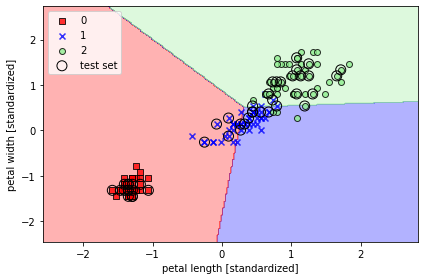

In [13]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    #마커와 컬러맵
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue','lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 디시전 경계
    x1_min, x1_max = X[:, 0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:, 1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                   y = X[y==cl,1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolors='black')
        
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')   

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 3.3 로지스틱 회귀

### 로지스틱 회귀 설명
* 퍼셉트론 : 선형모델 ( 비선형 모델은 수렴불가 )
* Odd : 특정 사건이 발생할 확률 $p$ 
* Odds ratio : $p \over (1-p)$
* 로짓함수
    * $logit(p) = \log { p \over (1-p) }$
    * $logit(p(y=1|x) = w_0x_0 +w_1x_1+...+w_mx_m = \sum_{i=0}^{m}w_ix_i=w^Tx$
* 로지스틱 시그모이드 함수 (시그모이드 함수) : 로짓의 역함수
    * $\phi(z)={1\over1+e^{-z}}$
    * $ z = w^Tx $
$$\phi_i(z)=P(y=i|x;w)$$

In [14]:
import numpy as np

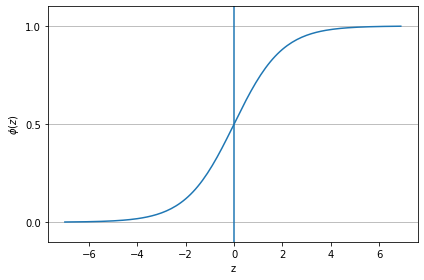

In [15]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7,7,0.1)
phi_z = sigmoid(z)
plt.plot(z,phi_z)

plt.axvline(0.0)
plt.ylim(-0.1,1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### 로지스틱 비용 함수의 가중치 학습

* 제곱 오차합 비용 함수
$$ J(w) = \sum_{i}{1\over2}(\phi(z^{(i)}) - y^{(i)})^2$$
* 우도(가능도) (likelihood) $L$
    - 특정 사건이 발생했을때 어떤 확률 분포에서 왔을지에 대한 확률

    - 데이터셋에 있는 샘플이 독립이라고 가정
    
    $$L(w)=P(y|x;w)=\prod^{n}_{i=1}P(y^{(i)}|x^{(i)};w) = \prod^{n}_{i=1} (\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)}))^{1-y^{(i)}} $$
    $$l(w) = \log L(w) = -J(w)$$
    - 로그 가능도 함수와 그로부터 만들어진 비용 함수 ( 로그 함수로 바꾸면 곱이 합으로 바뀌면서 도함수를 구하기 쉽다)
    - 비용 함수로 바꿔서 표현하면 경사 하강법을 사용하여 최적화 ( 그 이전의 경우는 경사 상승법)
    - $y$ : 확률 분포 $x$ : 관측값
    

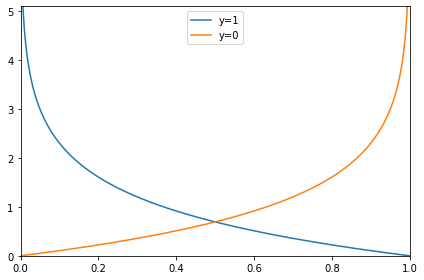

In [16]:
def cost_1(z) :
    return -np.log(sigmoid(z))

def cost_0(z) :
    return -np.log(1-sigmoid(z))

z = np.arange(-10,10,0.1)
phi_z= sigmoid(z)
c1 = [cost_1(x) for x in z]
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c1, label = "y=1")
plt.plot(phi_z, c0, label = "y=0")

plt.ylim(0.0,5.1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- 클래스에 따른 비용함수. 클래스 1에 속한 샘플을 1로 정확히 예측하면 비용이 0이 된다

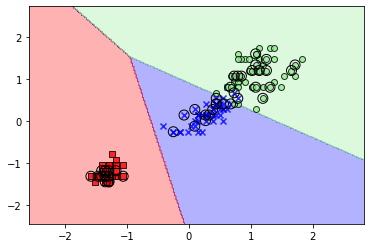

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', multi_class= 'auto', C = 100.0)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr, test_idx=range(105,150))
plt.show()

## 3.3.5 규제를 사용하여 과대적합 피하기

- 모델이 훈련 데이터로는 잘 작동하지만 그 외의 데이터에는 잘 작동하지 않음
    * 분산이 크다
    * 모델 파라미터가 너무 많아 복잡한 모델을 만들기 때문
    * 과소 적합 : 패턴을 감지할정도로 모델이 충분히 복잡하지 않음
    
- 규제 (regularization)
    * 공선성(collinearity, 특성간의 높은 상관관계)이나 데이터에서 잡음을 제거하여 과대적합 방지
    * 과도한 파라미터값을 제한하기 위해 추가적인 정보를 주입
    * L2 regularization $ {\lambda\over2} ||w|| = {\lambda\over2}\sum^m_{j=1} w^2_j$ : $\lambda$ - 규제 하이퍼 파라미터
    * $ J'(w) = J(w) + {\lambda\over2} ||w|| $
    * 로지스틱의 C는 람다의 역수

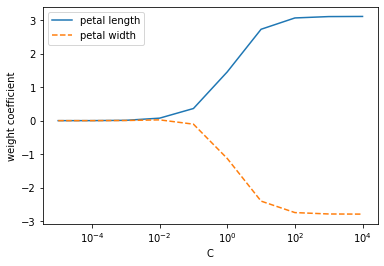

In [18]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

# C 값이 감소함에 따라 가중치 절대값이 감소한다

## 3.4 서포트 벡터 머신

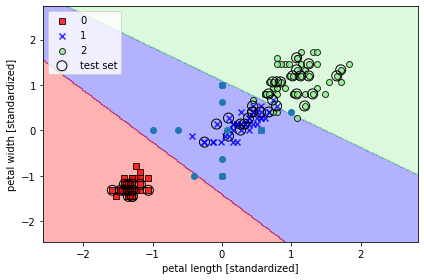

In [24]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.scatter(svm.dual_coef_[0, :], svm.dual_coef_[1, :])
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] >0,
                       X_xor[:,1] >0)
y_xor = np.where(y_xor, 1, -1)

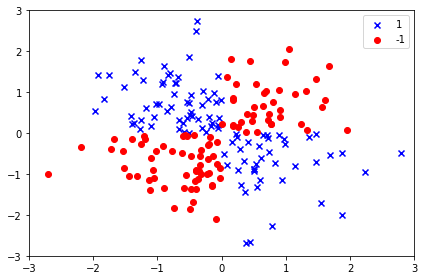

In [30]:
plt.scatter(X_xor[y_xor == 1, 0],
           X_xor[y_xor == 1, 1],
           c = 'b', marker='x', label = '1')
plt.scatter(X_xor[y_xor == -1, 0],
           X_xor[y_xor == -1, 1],
           c = 'r', marker='o', label = '-1')

plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

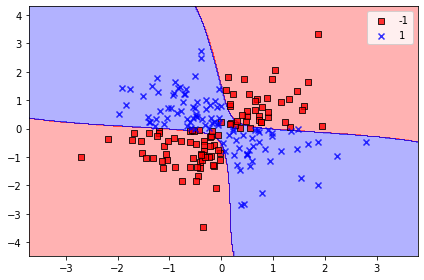

In [33]:
svm = SVC(kernel='rbf', gamma = 0.1, C = 10.)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [36]:
X_train_std.shape

(105, 2)

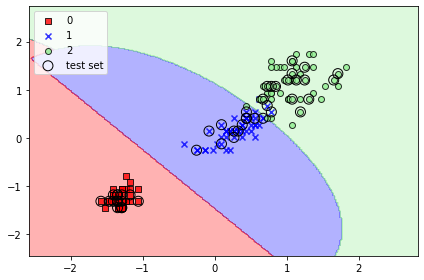

In [39]:
svm = SVC(kernel='rbf', gamma = 0.2, C = 10.)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

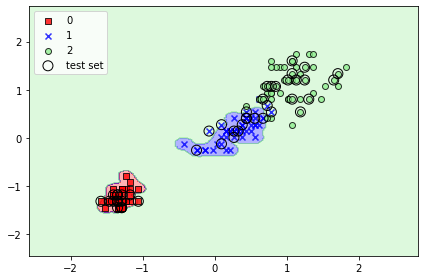

In [40]:
svm = SVC(kernel='rbf', gamma = 100, C = 10.)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150))
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

#감마가 커지면 오버피팅

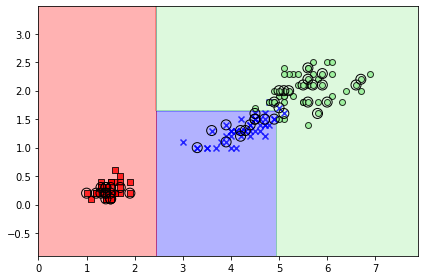

In [54]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)

tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105,150))

plt.tight_layout()
plt.show()

In [47]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

InvocationException: GraphViz's executables not found

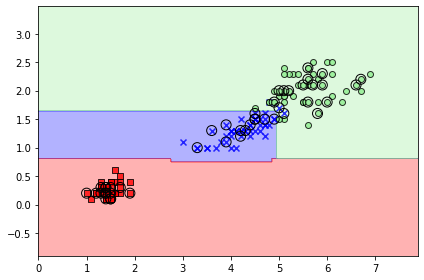

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=25, n_jobs=12)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105,150))

plt.tight_layout()
plt.show()